In [1]:
# you need PyVista and IFCOpenshell

Data loading complete. Found 152 damage instances.
Tunnel geometry parameters calculated. Center coordinates (X, Z): (4.858, 1.762)

Generating 3D solids for each damage contour based on your design concept...

Constructing accurate tunnel shell for visualization...

Successfully generated 152 valid damage solids, now visualizing...


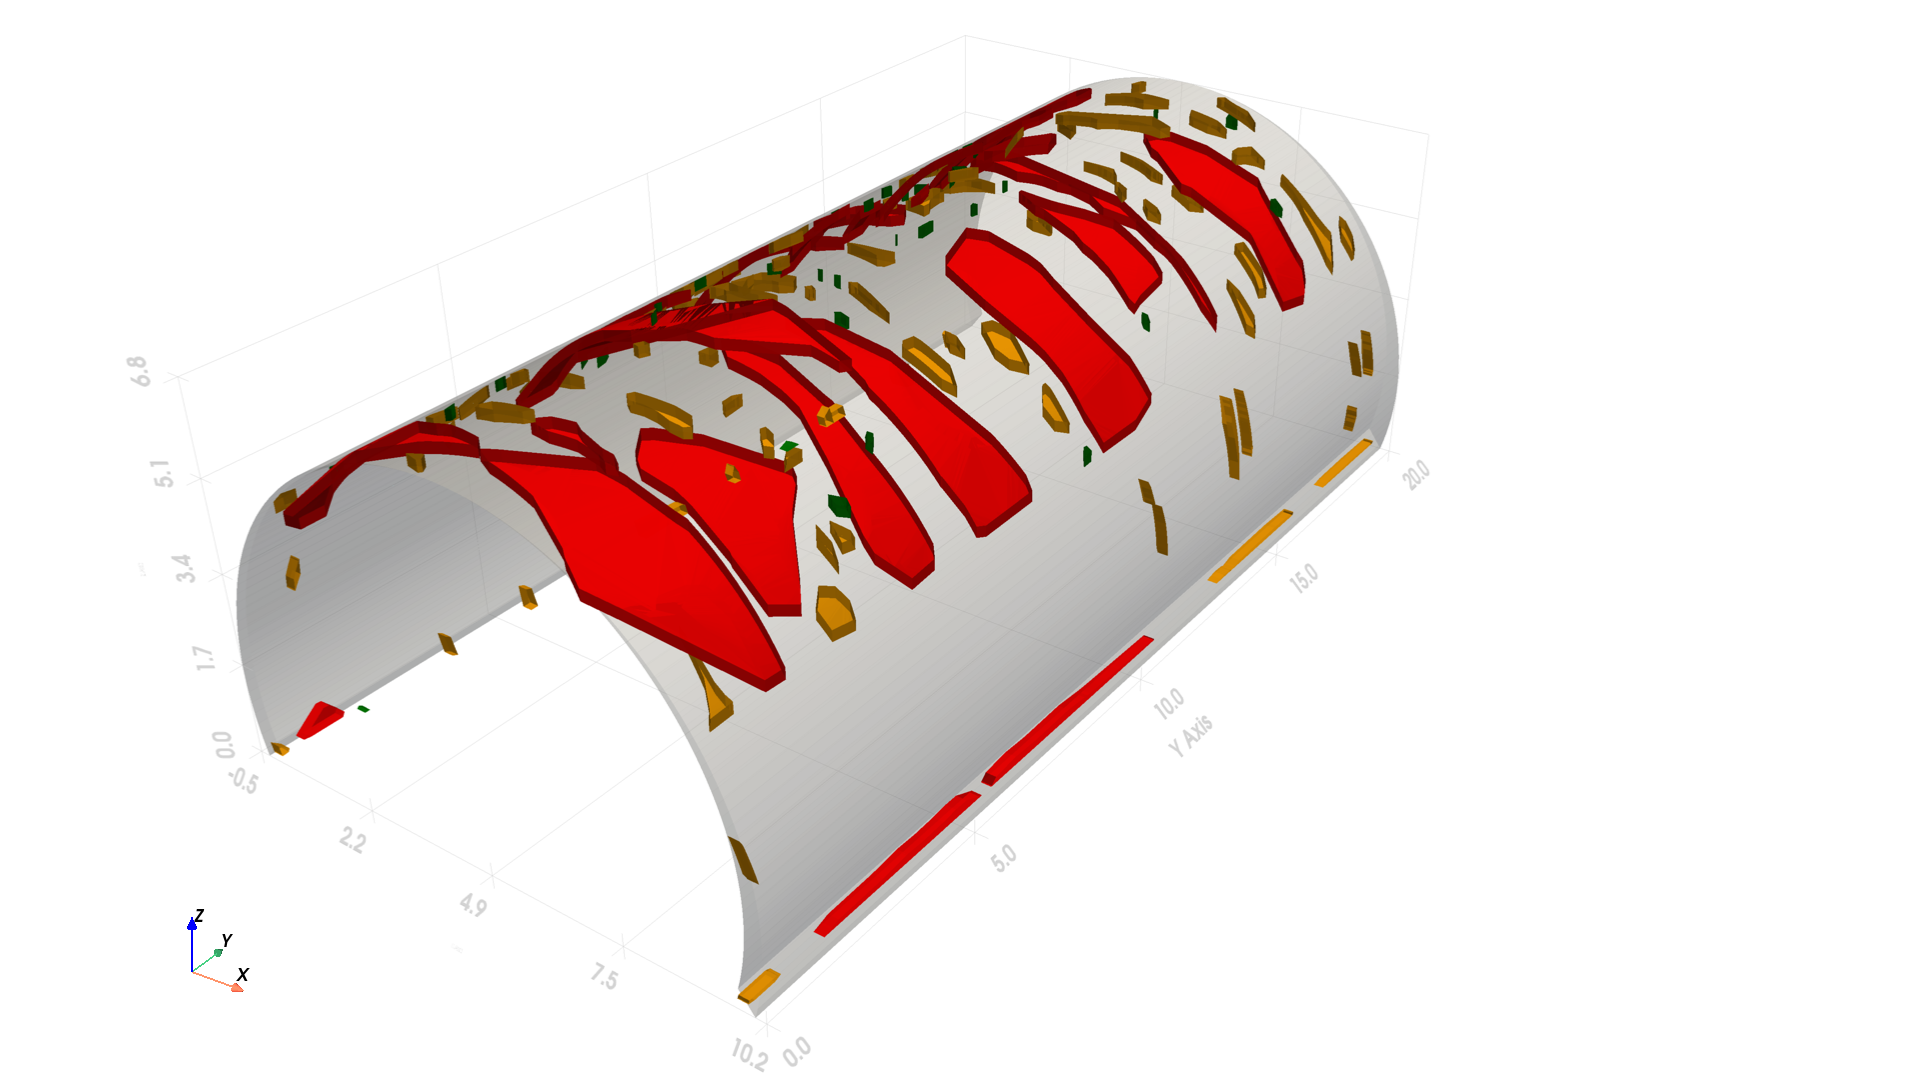


✅ Solid generation and cleanup complete.
The `damage_solids` and `grouped_lists` variables are now ready for IFC export.


In [1]:
import pyvista as pv
import numpy as np
import pandas as pd

pv.set_jupyter_backend('static') 

# ==========================
# 1. Load and prepare data
# ==========================
df = pd.read_csv('3d_point_info_with_zones.csv')
df['orig_index'] = np.arange(len(df))
df_sorted = df.sort_values(by=['instance_id', 'orig_index'])

grouped_lists = []
for inst_id, group in df_sorted.groupby('instance_id'):
    coords = group[['x','y','z']].values
    grouped_lists.append({
        'instance_id': inst_id,
        'points': coords,
        'risk': group['risk'].iloc[0],
        'zone': group['zone'].iloc[0],
        'category_name': group['category_name'].iloc[0],
        'area': group['area'].iloc[0]
    })
print(f"Data loading complete. Found {len(grouped_lists)} damage instances.")

# ==========================================================
# 2. Define and calculate unified tunnel geometry parameters
# ==========================================================
r_inner = 5.05
r_outer = 5.35
L = 20.0
s = 18.66
theta_max = s / r_inner
num_pts_geom = 100

tunnel_center_x = r_inner * np.sin(theta_max / 2)

angles = np.linspace(-theta_max/2, theta_max/2, num_pts_geom)
z_coords_on_arc_raw = -r_inner * (1 - np.cos(angles))
z_outer_raw = -r_outer * (1 - np.cos(np.linspace(theta_max/2, -theta_max/2, num_pts_geom)))
z_min_overall = min(z_coords_on_arc_raw.min(), z_outer_raw.min())

tunnel_center_z = -r_inner - z_min_overall

print(f"Tunnel geometry parameters calculated. Center coordinates (X, Z): ({tunnel_center_x:.3f}, {tunnel_center_z:.3f})")

# ==========================================================
# 3. Solid generation function based on your design concept
# ==========================================================
def get_cylindrical_coords(point):
    """Converts Cartesian coordinates to correct cylindrical coordinates (angle, longitudinal distance)"""
    x, y, z = point
    # Calculate angle from the tunnel center
    dx = x - tunnel_center_x
    dz = z - tunnel_center_z
    angle = np.arctan2(dx, dz)
    return angle, y

def generate_conforming_solid(points, zone, thickness=0.2, resolution=10):
    """
    Generates a damage solid conforming to the tunnel surface, following your design concept.
    
    1. Interpolate points on the cylinder surface to form a high-precision contour.
    2. Triangulate the contour to create a conforming base surface.
    3. Extrude the surface in the specified direction to form a solid.
    """
    if len(points) < 3: return None

    # --- Step 1: Create a high-precision, conforming, closed contour ---
    high_res_boundary_points = []
    
    # Iterate over each pair of adjacent points (including the last point to the first)
    for i in range(len(points)):
        p1 = points[i]
        p2 = points[(i + 1) % len(points)] # % len(points) ensures the last point connects back to the first

        # a. Convert Cartesian coordinates to cylindrical coordinates (angle, Y-coordinate)
        angle1, y1 = get_cylindrical_coords(p1)
        angle2, y2 = get_cylindrical_coords(p2)
        
        # Ensure continuity in angle interpolation (handling the jump from pi to -pi)
        if abs(angle2 - angle1) > np.pi:
            if angle2 > angle1: angle1 += 2 * np.pi
            else: angle2 += 2 * np.pi
                
        # b. Linearly interpolate in the cylindrical coordinate system
        interpolated_angles = np.linspace(angle1, angle2, resolution)
        interpolated_ys = np.linspace(y1, y2, resolution)
        
        # c. Convert the interpolated cylindrical coordinates back to Cartesian coordinates
        interp_x = r_inner * np.sin(interpolated_angles) + tunnel_center_x
        interp_z = r_inner * np.cos(interpolated_angles) + tunnel_center_z
        
        # Add the newly generated points to the contour list (excluding the last point of each segment to avoid duplicates)
        high_res_boundary_points.extend(np.column_stack([interp_x, interpolated_ys, interp_z])[:-1])

    if not high_res_boundary_points: return None
    high_res_boundary_points = np.array(high_res_boundary_points)

    # --- Step 2: Triangulate the high-precision contour to generate the base surface ---
    # First, create a PolyData object containing only the points
    boundary_poly = pv.PolyData(high_res_boundary_points)
    # Use Delaunay triangulation to fill this contour, forming a mesh surface
    base_surface = boundary_poly.delaunay_2d()

    if base_surface.n_points == 0 or base_surface.n_cells == 0:
        print(f"Warning: Delaunay 2D triangulation failed.")
        return None

    # --- Step 3: Extrude the base surface according to your designed zone rules to form a solid ---
    if zone == 'c': offset_vec = np.array([0, 0, -thickness])
    elif zone == 'l': offset_vec = np.array([-thickness, 0, 0])
    elif zone == 'r': offset_vec = np.array([thickness, 0, 0])
    else: # Default case or unknown zone
        offset_vec = np.array([0, 0, thickness])

    # Use PyVista's extrude function, which automatically creates sides and caps, forming a perfect closed solid
    solid = base_surface.extrude(offset_vec, capping=True)
    return solid

# ==========================
# 4. Generate and Clean All Damage Solids
# ==========================
damage_solids = []
print("\nGenerating 3D solids for each damage contour based on your design concept...")
for meta in grouped_lists:
    # Use our rewritten function based on your design to generate the solid
    solid = generate_conforming_solid(meta['points'], meta['zone'], thickness=0.2)
    if solid:
        # Critical step: Clean the mesh and unify normal directions in preparation for IFC export
        cleaned_solid = solid.clean().compute_normals(consistent_normals=True, auto_orient_normals=True)
        damage_solids.append(cleaned_solid)
    else:
        damage_solids.append(None)
        print(f"Warning: Instance {meta['instance_id']} failed to generate a solid.")

# Clean up failed entries to ensure damage_solids and grouped_lists correspond strictly
valid_indices = [i for i, s in enumerate(damage_solids) if s is not None]
damage_solids = [damage_solids[i] for i in valid_indices]
grouped_lists = [grouped_lists[i] for i in valid_indices]

# =============================================================
# 5. Visualize to Confirm Results (✅ Coordinate Labels Added)
# =============================================================
plotter = pv.Plotter(window_size=[1920, 1080])

# --- Accurately construct and visualize the tunnel shell ---
print("\nConstructing accurate tunnel shell for visualization...")
angles_inner_vis = np.linspace(-theta_max/2, theta_max/2, num_pts_geom)
x_inner_vis = r_inner * np.sin(angles_inner_vis) + tunnel_center_x
z_inner_vis = -r_inner * (1 - np.cos(angles_inner_vis)) - z_min_overall

angles_outer_vis = np.linspace(theta_max/2, -theta_max/2, num_pts_geom)
x_outer_vis = r_outer * np.sin(angles_outer_vis) + tunnel_center_x
z_outer_vis = -r_outer * (1 - np.cos(angles_outer_vis)) - z_min_overall

inner_points_vis = np.column_stack([x_inner_vis, np.zeros_like(x_inner_vis), z_inner_vis])
outer_points_vis = np.column_stack([x_outer_vis, np.zeros_like(x_outer_vis), z_outer_vis])

section_points_vis = np.vstack([inner_points_vis, outer_points_vis])
poly_vis = pv.PolyData(section_points_vis)

faces_vis = []
for i in range(num_pts_geom - 1):
    faces_vis.extend([4, i, i + 1, num_pts_geom + (num_pts_geom - 2 - i), num_pts_geom + (num_pts_geom - 1 - i)])
poly_vis.faces = np.array(faces_vis)
tunnel_shell_for_vis = poly_vis.extrude((0, L, 0), capping=True)

plotter.add_mesh(tunnel_shell_for_vis, color='lightgray', opacity=0.3, show_edges=False)

# --- Visualize damage solids ---
risk_color_map = {1:'red', 2:'orange', 3:'green'}
print(f"\nSuccessfully generated {len(damage_solids)} valid damage solids, now visualizing...")

# --- ✅ New: Prepare coordinate labels ---
# Create two lists, one for label positions and one for label text
label_points = []
label_texts = []
# -----------------------------

for i, solid in enumerate(damage_solids):
    # Add the damage solid mesh
    risk = grouped_lists[i]['risk']
    color = risk_color_map.get(risk, 'gray')
    plotter.add_mesh(solid, color=color, opacity=0.9, specular=0.5)
    
    # --- ✅ New: Prepare annotation info for each solid ---
    instance_id = grouped_lists[i]['instance_id']
    center_point = solid.center # Get the geometric center of the solid
    
    # Create the label text, including ID and formatted coordinates
    label_text = f"ID: {instance_id}\n({center_point[0]:.2f}, {center_point[1]:.2f}, {center_point[2]:.2f})"
    
    # Add the position and text to their respective lists
    label_points.append(center_point)
    label_texts.append(label_text)
    # ------------------------------------

# --- ✅ New: Add all labels at once after the loop ---
# This is more efficient than adding them one by one inside the loop
if label_points: # Only execute if there are labels to add
    plotter.add_point_labels(
        label_points,
        label_texts,
        font_size=10,
        shape_color='white',    # Label background color
        shape_opacity=0.7,      # Background opacity
        text_color='black',     # Text color
        shape='rounded_rect',   # Background shape
        point_size=0            # Do not display the point the label is pointing to
    )
# ---------------------------------------------
plotter.add_axes()
plotter.show_grid(color='lightgray')
plotter.camera_position = [(24,-15,20),(5,12,0),(0,0,1)]
plotter.enable_anti_aliasing('ssaa')
plotter.show()

print("\n✅ Solid generation and cleanup complete.")
print("The `damage_solids` and `grouped_lists` variables are now ready for IFC export.")

In [2]:
import ifcopenshell
import uuid

# =======================================================================
# Step 0: Prerequisites
# -----------------
# Ensure the damage_solids and grouped_lists variables are already correctly generated in the current environment.
# damage_solids: A list containing pyvista.PolyData objects.
# grouped_lists: A list containing metadata (dictionaries) for each object.
# =======================================================================

print(f"\nPreparing to export {len(damage_solids)} damage solids to an IFC file...")

# ========================
# Step 1: Initialize the IFC file (using the IFC2x3 schema)
# ========================
ifc_file = ifcopenshell.file(schema="IFC2X3")

# ========================
# Step 2: Create the basic IFC project structure (This is the necessary skeleton for BIM software to read the file correctly)
# ========================
print("Setting up IFC project structure...")

# Create Project
project = ifc_file.create_entity("IfcProject", GlobalId=str(uuid.uuid4()), Name="Tunnel Damage Assessment")

# Define Geometric Context
context = ifc_file.create_entity(
    "IfcGeometricRepresentationContext",
    ContextIdentifier="Body",
    ContextType="Model",
    CoordinateSpaceDimension=3,
    Precision=1e-5,
    WorldCoordinateSystem=ifc_file.create_entity(
        "IfcAxis2Placement3D",
        Location=ifc_file.create_entity("IfcCartesianPoint", Coordinates=(0.0, 0.0, 0.0))
    )
)

# Create Spatial Structure: Site -> Building -> BuildingStorey
site = ifc_file.create_entity("IfcSite", GlobalId=str(uuid.uuid4()), Name="Project Site")
building = ifc_file.create_entity("IfcBuilding", GlobalId=str(uuid.uuid4()), Name="Tunnel Structure")
storey = ifc_file.create_entity("IfcBuildingStorey", GlobalId=str(uuid.uuid4()), Name="Damage Location Level")

# Establish Aggregation Relationships (Add Site to Project, Building to Site, ...)
ifc_file.create_entity("IfcRelAggregates", GlobalId=str(uuid.uuid4()), RelatingObject=project, RelatedObjects=[site])
ifc_file.create_entity("IfcRelAggregates", GlobalId=str(uuid.uuid4()), RelatingObject=site, RelatedObjects=[building])
ifc_file.create_entity("IfcRelAggregates", GlobalId=str(uuid.uuid4()), RelatingObject=building, RelatedObjects=[storey])


# ========================
# Step 3: Iterate through each damage solid and create the corresponding IFC object
# ========================
print(f"Processing {len(damage_solids)} solids and converting to IFC format...")

# Use zip to pair the geometry with its metadata
for solid, meta in zip(damage_solids, grouped_lists):
    
    # a. Extract metadata and define the object name
    instance_id = meta['instance_id']
    category_name = meta['category_name']
    name = f"{category_name}_{instance_id}"

    # b. Convert geometry: from PyVista (vertices + faces) to IFC (IfcFacetedBrep)
    #   - Extract vertices (Vertices)
    #     ✅ Key fix: Ensure each coordinate is a standard Python float to avoid ValueError
    vertices = [tuple(map(float, p)) for p in solid.points]
    ifc_points = [ifc_file.create_entity("IfcCartesianPoint", Coordinates=v) for v in vertices]

    #   - Extract faces (Faces)
    ifc_faces = []
    faces_array = solid.faces
    i = 0
    while i < len(faces_array):
        num_vertices_in_face = faces_array[i]
        face_indices = faces_array[i + 1 : i + 1 + num_vertices_in_face]
        
        poly_loop = ifc_file.create_entity("IfcPolyLoop", Polygon=[ifc_points[j] for j in face_indices])
        # Since we unified the normals earlier, Orientation can safely be set to True
        outer_bound = ifc_file.create_entity("IfcFaceOuterBound", Bound=poly_loop, Orientation=True)
        ifc_face = ifc_file.create_entity("IfcFace", Bounds=[outer_bound])
        ifc_faces.append(ifc_face)
        
        i += num_vertices_in_face + 1

    #   - Assemble into a Closed Shell and a Faceted Brep (solid)
    closed_shell = ifc_file.create_entity("IfcClosedShell", CfsFaces=ifc_faces)
    faceted_brep = ifc_file.create_entity("IfcFacetedBrep", Outer=closed_shell)

    # c. Create Shape Representation
    shape_representation = ifc_file.create_entity(
        "IfcShapeRepresentation",
        ContextOfItems=context,
        RepresentationIdentifier="Body",
        RepresentationType="Brep", # Brep = Boundary Representation, represents a solid
        Items=[faceted_brep]
    )
    product_shape = ifc_file.create_entity("IfcProductDefinitionShape", Representations=[shape_representation])

    # d. Create IFC Product (IfcBuildingElementProxy is a good, generic choice)
    product = ifc_file.create_entity(
        "IfcBuildingElementProxy",
        GlobalId=str(uuid.uuid4()),
        Name=name,
        Representation=product_shape
    )

    # e. Place the product in space (coordinates are already world coordinates, so place relative to origin)
    placement = ifc_file.create_entity(
        "IfcLocalPlacement",
        RelativePlacement=ifc_file.create_entity(
            "IfcAxis2Placement3D",
            Location=ifc_file.create_entity("IfcCartesianPoint", Coordinates=(0.0, 0.0, 0.0))
        )
    )
    product.ObjectPlacement = placement

    # f. Create a Property Set and attach your specified metadata
    pset = ifc_file.create_entity("IfcPropertySet", GlobalId=str(uuid.uuid4()), Name=f"Pset_{name}")
    
    properties = [
        ifc_file.create_entity("IfcPropertySingleValue", Name="instance_id", NominalValue=ifc_file.create_entity("IfcInteger", int(instance_id))),
        ifc_file.create_entity("IfcPropertySingleValue", Name="category_name", NominalValue=ifc_file.create_entity("IfcLabel", str(category_name))),
        ifc_file.create_entity("IfcPropertySingleValue", Name="risk", NominalValue=ifc_file.create_entity("IfcInteger", int(meta.get('risk', 0)))),
        ifc_file.create_entity("IfcPropertySingleValue", Name="area", NominalValue=ifc_file.create_entity("IfcReal", float(meta.get('area', 0.0))))
    ]
    pset.HasProperties = properties
    
    #   - Associate the property set with the product
    ifc_file.create_entity(
        "IfcRelDefinesByProperties",
        GlobalId=str(uuid.uuid4()),
        RelatedObjects=[product],
        RelatingPropertyDefinition=pset
    )

    # g. Place the product into the building storey (spatial containment)
    ifc_file.create_entity(
        "IfcRelContainedInSpatialStructure",
        GlobalId=str(uuid.uuid4()),
        RelatedElements=[product],
        RelatingStructure=storey
    )

print("All solids processed.")

# ========================
# Step 4: Write the IFC file
# ========================
output_filename = "tunnel_damages_output_test.ifc"
ifc_file.write(output_filename)

print(f"\n🎉 Success! IFC file has been generated: {output_filename}")
print("You can now import this file into any BIM software that supports IFC2x3.")


Preparing to export 152 damage solids to an IFC file...
Setting up IFC project structure...
Processing 152 solids and converting to IFC format...
All solids processed.

🎉 Success! IFC file has been generated: tunnel_damages_output_test.ifc
You can now import this file into any BIM software that supports IFC2x3.
